<span style="color:#FF4500; font-size: 40px; font-weight: bold; font-style: italic;">Identificación de factores influyentes en el diagnóstico tardío del cancer de mama metastásico</span>

<span style="color:#FFA07A; font-size: 30px; font-weight: bold;">[Código 2] Agrupación de variables </span>

<span style="color:#FAF0E6; font-size: 24px; font-style: italic;">Integrantes</span>
<ul>
    <li><span style="color:#FAF0E6; font-size: 18px;">CORDOVA DELGADO, Marietha Kristeen Alexandra</span></li>
    <li><span style="color:#FAF0E6; font-size: 18px;">GUEVARA PERALTA, Sebastian Antonio Valentino</span></li>
    <li><span style="color:#FAF0E6; font-size: 18px;">MENDOZA MECHAN, Maria del Carmen</span></li>
    <li><span style="color:#FAF0E6; font-size: 18px;">TAMARIZ PANTOJA, Fiorella Ariana</span></li>
    <li><span style="color:#FAF0E6; font-size: 18px;">WIESSE PAREDES, Santiago</span></li>
    

<span style="color:#F5F5DC; font-size: 19px; font-weight: lighter;">Descripción: En este código se procederá con (1) la agrupación de las variables a nivel de código postal las cuales se encuentren en rangos, a modo de disminuir la cantidad de variables total.</span>

<span style="color:#00CED1; font-size: 24px; font-weight: bold; font-style: italic">Importación de librerías</span>

In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

<span style="color:#00CED1; font-size: 24px; font-weight: bold; font-style: italic">Lectura de archivos</span>

In [64]:
train_clean = pd.read_csv("train_clean.csv")
test_clean = pd.read_csv("test_clean.csv")

<span style="color:#00CED1; font-size: 24px; font-weight: bold; font-style: italic">Fórmulas de agrupación</span>

In [65]:
def create_age_range_column(df):
   
    df_result = df.copy()
    
    conditions = [
        df_result['patient_age'] < 10,
        (df_result['patient_age'] >= 10) & (df_result['patient_age'] <= 19),
        (df_result['patient_age'] >= 20) & (df_result['patient_age'] <= 29),
        (df_result['patient_age'] >= 30) & (df_result['patient_age'] <= 39),
        (df_result['patient_age'] >= 40) & (df_result['patient_age'] <= 49),
        (df_result['patient_age'] >= 50) & (df_result['patient_age'] <= 59),
        (df_result['patient_age'] >= 60) & (df_result['patient_age'] <= 69),
        (df_result['patient_age'] >= 70) & (df_result['patient_age'] <= 79),
        df_result['patient_age'] >= 80
    ]
    
    choices = [
        df_result['age_under_10'],
        df_result['age_10_to_19'],
        df_result['age_20s'],
        df_result['age_30s'],
        df_result['age_40s'],
        df_result['age_50s'],
        df_result['age_60s'],
        df_result['age_70s'],
        df_result['age_over_80']
    ]
    
    age_range_values = np.select(conditions, choices, default=np.nan)
    df_result.insert(23, 'age_range', age_range_values)

    return df_result

train_clean = create_age_range_column(train_clean)

In [66]:
columnas_elim = ['age_under_10', 'age_10_to_19', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80']
train_clean = train_clean.drop(columns=columnas_elim)
train_clean.shape

(12906, 70)

In [67]:
def create_race_range_column(df, race_column='patient_race', position=61):
    
    df_result = df.copy()
    
    conditions = [
        df_result[race_column] == 'White',
        df_result[race_column] == 'Black', 
        df_result[race_column] == 'Asian',
        df_result[race_column] == 'Hispanic',
        df_result[race_column] == 'Other'
    ]
    
    choices = [
        df_result['race_white'],
        df_result['race_black'],
        df_result['race_asian'],
        df_result['hispanic'],
        df_result['race_other']
    ]
    
    race_range_values = np.select(conditions, choices, default=np.nan)
    
    df_result.insert(position, 'race_range', race_range_values)
    
    return df_result

train_clean = create_race_range_column(train_clean)
train_clean.shape

(12906, 71)

In [68]:
columnas_elim = ['race_white', 'race_black', 'race_asian', 'race_native', 'race_pacific', 'race_other', 'race_multiple', 'hispanic']
train_clean = train_clean.drop(columns=columnas_elim)
train_clean.shape

(12906, 63)

In [69]:
columnas_elim = ['patient_id','patient_zip3']
train_clean = train_clean.drop(columns=columnas_elim)
train_clean.shape

(12906, 61)

<span style="color:#00CED1; font-size: 24px; font-weight: bold; font-style: italic">Comparación de técnicas de selección de características</span>

In [70]:
# ================ Feature selection (selección de variables) ================ #
k = 15

# Separar features y target
X_train = train_clean.drop('DiagPeriodL90D', axis=1)
y_train = train_clean['DiagPeriodL90D']

# Test set solo tiene features
X_test = test_clean.copy()  # No hay columna 'diagnostico' en test

In [71]:
# Verificar que las columnas coincidan
if not all(col in X_test.columns for col in X_train.columns):
    print("WARNING: Las columnas no coinciden entre train y test")
    # Usar solo las columnas que están en ambos
    common_cols = [col for col in X_train.columns if col in X_test.columns]
    X_train = X_train[common_cols]
    X_test = X_test[common_cols]
    print(f"Usando columnas comunes: {len(common_cols)}")

train_clean = X_train

# numerical
float_cols = train_clean.select_dtypes(include=['float64']).columns.tolist()
gradient_cols = ['patient_age'] + float_cols

# categorical
categorical_cols = train_clean.select_dtypes(include=['object','int64']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'patient_age']

gradient_cols = [col for col in gradient_cols if col in X_train.columns]
categorical_cols = [col for col in categorical_cols if col in X_train.columns]

# Para Mutual Info y Random Forest: usar datos originales
X_train_original = X_train.copy()
X_test_original = X_test.copy()

# Para Chi2: necesitamos encoder para categóricas y scaling para valores positivos
X_train_chi2 = X_train.copy()
X_test_chi2 = X_test.copy()

# Aplicar LabelEncoder a categóricas para Chi2
label_encoders = {}
for col in categorical_cols:
    if col in X_train_chi2.columns:
        le = LabelEncoder()
        X_train_chi2[col] = le.fit_transform(X_train_chi2[col].astype(str))

        try:
            X_test_chi2[col] = le.transform(X_test_chi2[col].astype(str))
        except ValueError:
            print(f"WARNING: Valores nuevos en test para {col}, usando valor por defecto")
            X_test_chi2[col] = le.transform(X_test_chi2[col].astype(str).apply(
                lambda x: x if x in le.classes_ else le.classes_[0]
            ))
        label_encoders[col] = le

print(f"\nForma del conjunto de entrenamiento: {X_train.shape}")
print(f"Forma del conjunto de prueba: {X_test.shape}")


Usando columnas comunes: 58

Forma del conjunto de entrenamiento: (12906, 58)
Forma del conjunto de prueba: (5792, 58)



Variables categóricas (tu definición): ['patient_race', 'payer_type', 'patient_state', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'Region', 'Division']
Variables numéricas/gradiente: ['patient_age', 'patient_age', 'population', 'density', 'age_median', 'male', 'female', 'married', 'divorced', 'never_married', 'widowed', 'family_size', 'family_dual_income', 'income_household_median', 'income_household_under_5', 'income_household_5_to_10', 'income_household_10_to_15', 'income_household_15_to_20', 'income_household_20_to_25', 'income_household_25_to_35', 'income_household_35_to_50', 'income_household_50_to_75', 'income_household_75_to_100', 'income_household_100_to_150', 'income_household_150_over', 'income_household_six_figure', 'income_individual_median', 'home_ownership', 'housing_units', 'home_value', 'rent_median', 'rent_burden', 'education_less_highschool', 'education_highschool', 'education_some_college', 'education_bachelors', 'education_graduate', 'educa

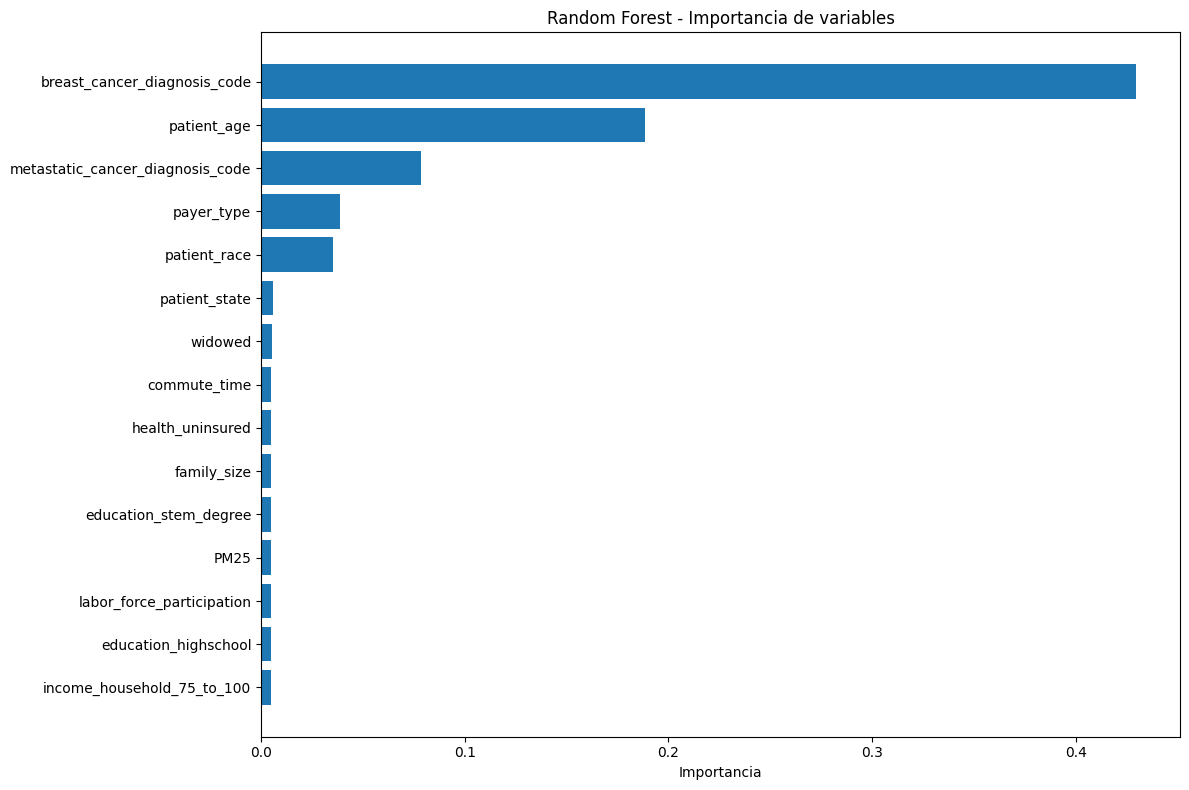


MÉTODO 2: MUTUAL INFORMATION

Top 15 - Mutual Information:
 1. breast_cancer_diagnosis_code: 0.1866
 2. patient_age: 0.0204
 3. income_household_10_to_15: 0.0186
 4. income_household_15_to_20: 0.0163
 5. family_dual_income: 0.0140
 6. density: 0.0137
 7. disabled: 0.0130
 8. income_household_under_5: 0.0126
 9. education_highschool: 0.0126
10. education_graduate: 0.0122
11. home_value: 0.0121
12. income_household_35_to_50: 0.0117
13. metastatic_cancer_diagnosis_code: 0.0107
14. married: 0.0104
15. divorced: 0.0103


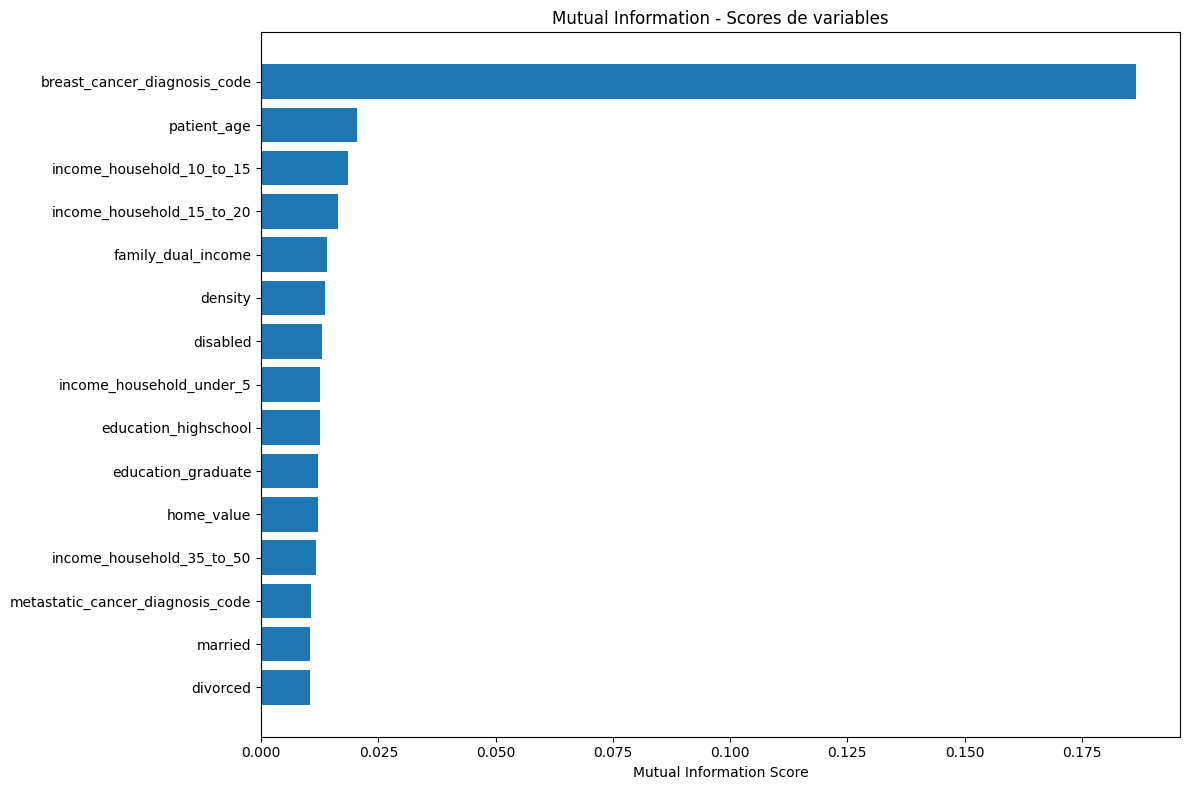


MÉTODO 3: CHI-CUADRADO

Top 15 - Chi-cuadrado:
 1. breast_cancer_diagnosis_code: 580.4433
 2. metastatic_cancer_diagnosis_code: 37.5758
 3. patient_state: 3.2272
 4. patient_age: 2.3626
 5. payer_type: 2.2807
 6. home_value: 1.4852
 7. health_uninsured: 1.2067
 8. education_less_highschool: 1.0723
 9. education_bachelors: 1.0601
10. density: 1.0135
11. education_college_or_above: 0.8522
12. Region: 0.7649
13. rent_median: 0.7294
14. income_household_10_to_15: 0.6610
15. poverty: 0.6220


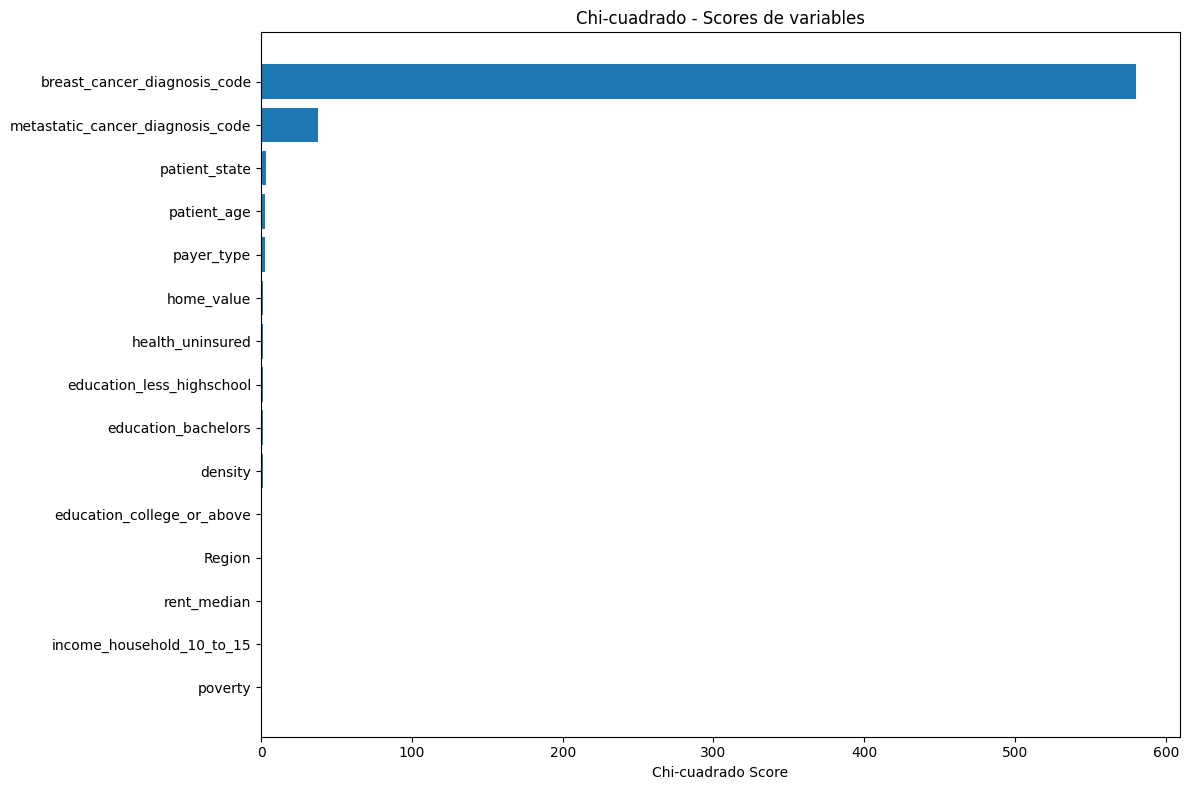

In [72]:
# Verificar que las columnas coincidan
if not all(col in X_test.columns for col in X_train.columns):
    print("WARNING: Las columnas no coinciden entre train y test")
    # Usar solo las columnas que están en ambos
    common_cols = [col for col in X_train.columns if col in X_test.columns]
    X_train = X_train[common_cols]
    X_test = X_test[common_cols]
    print(f"Usando columnas comunes: {len(common_cols)}")

# Usar tu definición previa
train_clean = X_train  # Usar X_train en lugar de train_clean para consistencia

# numerical 
float_cols = train_clean.select_dtypes(include=['float64']).columns.tolist()
gradient_cols = ['patient_age'] + float_cols

# categorical
categorical_cols = train_clean.select_dtypes(include=['object','int64']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'patient_age']

# Filtrar solo las columnas que existen en nuestros datos
gradient_cols = [col for col in gradient_cols if col in X_train.columns]
categorical_cols = [col for col in categorical_cols if col in X_train.columns]

print(f"\nVariables categóricas (tu definición): {categorical_cols}")
print(f"Variables numéricas/gradiente: {gradient_cols}")
print(f"Total categóricas: {len(categorical_cols)}")
print(f"Total numéricas: {len(gradient_cols)}")

# ========== Preparar datos para cada método ================================= #
# Aplicar LabelEncoder a TODAS las variables categóricas
# (sklearn RandomForest requiere datos numéricos)
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

label_encoders = {}
print(f"\nAplicando Label Encoding a variables categóricas:")
for col in categorical_cols:
    if col in X_train_encoded.columns:  # Verificar que la columna existe
        print(f"  - Encoding: {col}")
        le = LabelEncoder()
        X_train_encoded[col] = le.fit_transform(X_train_encoded[col].astype(str))
        # Para test, manejar posibles valores nuevos
        try:
            X_test_encoded[col] = le.transform(X_test_encoded[col].astype(str))
        except ValueError:
            # Si hay valores nuevos en test, usar un valor por defecto
            print(f"    WARNING: Valores nuevos en test para {col}, usando valor por defecto")
            X_test_encoded[col] = le.transform(X_test_encoded[col].astype(str).apply(
                lambda x: x if x in le.classes_ else le.classes_[0]
            ))
        label_encoders[col] = le

# Para todos los métodos: usar datos con encoding
X_train_original = X_train_encoded.copy()
X_test_original = X_test_encoded.copy()

# Para Chi2: además del encoding, aplicar scaling
X_train_chi2 = X_train_encoded.copy()
X_test_chi2 = X_test_encoded.copy()

print(f"\nForma del conjunto de entrenamiento: {X_train.shape}")
print(f"Forma del conjunto de prueba: {X_test.shape}")

# ========================== [1] Random Forest ============================== #
print("\n" + "="*60)
print("MÉTODO 1: RANDOM FOREST")
print("="*60)

# Aplicación del modelo Random Forest (maneja categóricas automáticamente)
rf_model = RandomForestClassifier(
    n_estimators=500, 
    random_state=123,
    n_jobs=-1
)

# Entrenar modelo con datos originales
rf_model.fit(X_train_original, y_train)

# Como no tenemos y_test, solo mostramos el modelo entrenado
print("=== Modelo Random Forest entrenado ===")
print(f"Features utilizadas: {X_train_original.shape[1]}")
print(f"Muestras de entrenamiento: {X_train_original.shape[0]}")

# Si quieres, puedes hacer predicciones en test (sin evaluar)
rf_test_predictions = rf_model.predict(X_test_original)
print(f"\nPredicciones en test generadas: {len(rf_test_predictions)}")
print(f"Distribución de predicciones: {np.bincount(rf_test_predictions)}")

# Variables más importantes - Top k
rf_importance = rf_model.feature_importances_
rf_features = X_train_original.columns

# Crear DataFrame con importancias
rf_importance_df = pd.DataFrame({
    'Variable': rf_features,
    'Importance': rf_importance
}).sort_values('Importance', ascending=False)

top_k_rf = rf_importance_df.head(k)['Variable'].tolist()
print(f"\nTop {k} - Random Forest:")
for i, var in enumerate(top_k_rf, 1):
    importance = rf_importance_df[rf_importance_df['Variable'] == var]['Importance'].iloc[0]
    print(f"{i:2d}. {var}: {importance:.4f}")

# Gráfico de importancia
plt.figure(figsize=(12, 8))
plt.barh(range(k), rf_importance_df.head(k)['Importance'])
plt.yticks(range(k), rf_importance_df.head(k)['Variable'])
plt.xlabel('Importancia')
plt.title('Random Forest - Importancia de variables')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ====================== [2] Mutual Information ============================ #
print("\n" + "="*60)
print("MÉTODO 2: MUTUAL INFORMATION")
print("="*60)

# Calcular mutual information 
# Nota: mutual_info_classif puede manejar variables categóricas si se especifica,
# pero usaremos datos encoded para consistencia
mi_scores = mutual_info_classif(X_train_original, y_train, random_state=123)

# Crear DataFrame con scores
mi_df = pd.DataFrame({
    'Variable': X_train_original.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

top_k_mi = mi_df.head(k)['Variable'].tolist()
print(f"\nTop {k} - Mutual Information:")
for i, var in enumerate(top_k_mi, 1):
    score = mi_df[mi_df['Variable'] == var]['MI_Score'].iloc[0]
    print(f"{i:2d}. {var}: {score:.4f}")

# Gráfico de mutual information
plt.figure(figsize=(12, 8))
plt.barh(range(k), mi_df.head(k)['MI_Score'])
plt.yticks(range(k), mi_df.head(k)['Variable'])
plt.xlabel('Mutual Information Score')
plt.title('Mutual Information - Scores de variables')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ========================== [3] Chi-cuadrado ============================== #
print("\n" + "="*60)
print("MÉTODO 3: CHI-CUADRADO")
print("="*60)

# Escalar datos para chi2 (necesita valores no negativos)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_chi2)
X_test_scaled = scaler.transform(X_test_chi2)

# Aplicar SelectKBest con chi2
chi2_selector = SelectKBest(score_func=chi2, k=k)
chi2_selector.fit(X_train_scaled, y_train)

# Obtener scores y variables seleccionadas
chi2_scores = chi2_selector.scores_
chi2_selected_features = X_train_chi2.columns[chi2_selector.get_support()]

# Crear DataFrame con scores
chi2_df = pd.DataFrame({
    'Variable': X_train_chi2.columns,
    'Chi2_Score': chi2_scores
}).sort_values('Chi2_Score', ascending=False)

top_k_chi2 = chi2_df.head(k)['Variable'].tolist()
print(f"\nTop {k} - Chi-cuadrado:")
for i, var in enumerate(top_k_chi2, 1):
    score = chi2_df[chi2_df['Variable'] == var]['Chi2_Score'].iloc[0]
    print(f"{i:2d}. {var}: {score:.4f}")

# Gráfico de chi-cuadrado
plt.figure(figsize=(12, 8))
plt.barh(range(k), chi2_df.head(k)['Chi2_Score'])
plt.yticks(range(k), chi2_df.head(k)['Variable'])
plt.xlabel('Chi-cuadrado Score')
plt.title('Chi-cuadrado - Scores de variables')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [73]:

# ============================================================================ #
# ========================== Comparación de métodos ========================== #
# ============================================================================ #

print("\n" + "="*60)
print("COMPARACIÓN DE MÉTODOS")
print("="*60)

# DataFrame para comparación
max_len = max(len(top_k_rf), len(top_k_mi), len(top_k_chi2))
comparison_df = pd.DataFrame({
    'Rank': range(1, k+1),
    'Random_Forest': top_k_rf + [None] * (k - len(top_k_rf)),
    'Mutual_Information': top_k_mi + [None] * (k - len(top_k_mi)),
    'Chi2': top_k_chi2 + [None] * (k - len(top_k_chi2))
})

print("\nComparación por ranking:")
print(comparison_df.to_string(index=False))

# ========== Variables que se repiten entre métodos ========================= #
all_vars = list(set(top_k_rf + top_k_mi + top_k_chi2))
all_vars = [var for var in all_vars if var is not None]

# Matriz de coincidencias
coincidence_data = []
for var in all_vars:
    coincidence_data.append({
        'Variable': var,
        'RF': var in top_k_rf,
        'MI': var in top_k_mi,
        'Chi2': var in top_k_chi2,
        'Count': sum([var in top_k_rf, var in top_k_mi, var in top_k_chi2])
    })

coincidence_df = pd.DataFrame(coincidence_data)
coincidence_df = coincidence_df.sort_values(['Count', 'Variable'], ascending=[False, True])

print("\n" + "="*50)
print("ANÁLISIS DE COINCIDENCIAS")
print("="*50)
print("\nVariables por método y frecuencia:")
print(coincidence_df.to_string(index=False))

# Variables que aparecen en los 3 métodos
consensus_vars = coincidence_df[coincidence_df['Count'] == 3]['Variable'].tolist()
print(f"\nVariables seleccionadas por los 3 métodos ({len(consensus_vars)}):")
for var in consensus_vars:
    print(f"- {var}")

# Variables que aparecen en 2 métodos
two_methods_vars = coincidence_df[coincidence_df['Count'] == 2]['Variable'].tolist()
print(f"\nVariables seleccionadas por 2 métodos ({len(two_methods_vars)}):")
for var in two_methods_vars:
    print(f"- {var}")



COMPARACIÓN DE MÉTODOS

Comparación por ranking:
 Rank                    Random_Forest               Mutual_Information                             Chi2
    1     breast_cancer_diagnosis_code     breast_cancer_diagnosis_code     breast_cancer_diagnosis_code
    2                      patient_age                      patient_age metastatic_cancer_diagnosis_code
    3 metastatic_cancer_diagnosis_code        income_household_10_to_15                    patient_state
    4                       payer_type        income_household_15_to_20                      patient_age
    5                     patient_race               family_dual_income                       payer_type
    6                    patient_state                          density                       home_value
    7                          widowed                         disabled                 health_uninsured
    8                     commute_time         income_household_under_5        education_less_highschool
    9

In [74]:
# ============================================================================ #
# ================== Evaluación de rendimiento por método ==================== #
# ============================================================================ #

print("\n" + "="*60)
print("EVALUACIÓN DE RENDIMIENTO (Solo validación cruzada en train)")
print("="*60)

# Función para evaluar rendimiento con validación cruzada
def evaluate_feature_set(X_train, y_train, feature_list, method_name):
    """Evalúa el rendimiento de un conjunto de features usando Random Forest"""
    if len(feature_list) == 0:
        return None
    
    # Usar datos originales para evaluación (Random Forest maneja categóricas)
    X_selected = X_train_original[feature_list]
    
    # Validación cruzada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    scores = cross_val_score(
        RandomForestClassifier(n_estimators=100, random_state=123),
        X_selected, y_train, cv=cv, scoring='accuracy'
    )
    
    print(f"\n{method_name}:")
    print(f"  Accuracy CV: {scores.mean():.4f} (±{scores.std()*2:.4f})")
    print(f"  Número de features: {len(feature_list)}")
    
    return scores.mean()

# Evaluar cada método
rf_performance = evaluate_feature_set(X_train_original, y_train, top_k_rf, "Random Forest Features")
mi_performance = evaluate_feature_set(X_train_original, y_train, top_k_mi, "Mutual Information Features")
chi2_performance = evaluate_feature_set(X_train_original, y_train, top_k_chi2, "Chi-cuadrado Features")

# Evaluar variables de consenso
if consensus_vars:
    consensus_performance = evaluate_feature_set(X_train_original, y_train, consensus_vars, "Consensus Features (3 métodos)")

# Evaluar variables que aparecen en al menos 2 métodos
at_least_two = coincidence_df[coincidence_df['Count'] >= 2]['Variable'].tolist()
if at_least_two:
    two_plus_performance = evaluate_feature_set(X_train_original, y_train, at_least_two, "Features (≥2 métodos)")



EVALUACIÓN DE RENDIMIENTO (Solo validación cruzada en train)

Random Forest Features:
  Accuracy CV: 0.7790 (±0.0126)
  Número de features: 15

Mutual Information Features:
  Accuracy CV: 0.7690 (±0.0086)
  Número de features: 15

Chi-cuadrado Features:
  Accuracy CV: 0.7766 (±0.0077)
  Número de features: 15

Consensus Features (3 métodos):
  Accuracy CV: 0.7765 (±0.0216)
  Número de features: 3

Features (≥2 métodos):
  Accuracy CV: 0.7843 (±0.0122)
  Número de features: 10


In [75]:

# ============================================================================ #
# ==================== Generar predicciones finales ========================== #
# ============================================================================ #

print("\n" + "="*60)
print("GENERAR PREDICCIONES FINALES EN TEST")
print("="*60)

def generate_predictions(feature_list, method_name):
    """Genera predicciones finales usando las features seleccionadas"""
    if len(feature_list) == 0:
        return None
    
    # Entrenar en train completo
    X_train_selected = X_train_original[feature_list]
    X_test_selected = X_test_original[feature_list]
    
    rf_final = RandomForestClassifier(n_estimators=500, random_state=123)
    rf_final.fit(X_train_selected, y_train)
    
    # Generar predicciones
    test_predictions = rf_final.predict(X_test_selected)
    test_probabilities = rf_final.predict_proba(X_test_selected)
    
    print(f"\n{method_name}:")
    print(f"  Features utilizadas: {len(feature_list)}")
    print(f"  Predicciones generadas: {len(test_predictions)}")
    print(f"  Distribución: No supera={np.sum(test_predictions==0)}, Supera={np.sum(test_predictions==1)}")
    
    # Guardar predicciones
    predictions_df = pd.DataFrame({
        'prediction': test_predictions,
        'prob_no_supera': test_probabilities[:, 0],
        'prob_supera': test_probabilities[:, 1]
    })
    
    filename = f"predictions_{method_name.lower().replace(' ', '_')}.csv"
    predictions_df.to_csv(filename, index=False)
    print(f"  Predicciones guardadas en: {filename}")
    
    return test_predictions

# Generar predicciones con cada método
print("Generando predicciones finales:")
rf_predictions = generate_predictions(top_k_rf, "Random_Forest")
mi_predictions = generate_predictions(top_k_mi, "Mutual_Information")  
chi2_predictions = generate_predictions(top_k_chi2, "Chi2")

if consensus_vars:
    consensus_predictions = generate_predictions(consensus_vars, "Consensus")
if at_least_two:
    two_plus_predictions = generate_predictions(at_least_two, "Two_Plus_Methods")


GENERAR PREDICCIONES FINALES EN TEST
Generando predicciones finales:

Random_Forest:
  Features utilizadas: 15
  Predicciones generadas: 5792
  Distribución: No supera=1636, Supera=4156
  Predicciones guardadas en: predictions_random_forest.csv

Mutual_Information:
  Features utilizadas: 15
  Predicciones generadas: 5792
  Distribución: No supera=1731, Supera=4061
  Predicciones guardadas en: predictions_mutual_information.csv

Chi2:
  Features utilizadas: 15
  Predicciones generadas: 5792
  Distribución: No supera=1669, Supera=4123
  Predicciones guardadas en: predictions_chi2.csv

Consensus:
  Features utilizadas: 3
  Predicciones generadas: 5792
  Distribución: No supera=1687, Supera=4105
  Predicciones guardadas en: predictions_consensus.csv

Two_Plus_Methods:
  Features utilizadas: 10
  Predicciones generadas: 5792
  Distribución: No supera=1604, Supera=4188
  Predicciones guardadas en: predictions_two_plus_methods.csv


In [76]:

# ============================================================================ #
# ================================ Resumen =================================== #
# ============================================================================ #

print("\n" + "="*60)
print("RESUMEN FINAL")
print("="*60)

print(f"\nDataset: {train_clean.shape[0]} muestras train, {test_clean.shape[0]} muestras test")
print(f"Features totales: {train_clean.shape[1]-1}")
print(f"Features categóricas: {len(categorical_cols)}")
print(f"Features numéricas/gradiente: {len(gradient_cols)}")
print(f"Features seleccionadas por método: {k}")

print(f"\nRendimiento por método (Accuracy CV en train):")
if rf_performance: print(f"- Random Forest: {rf_performance:.4f}")
if mi_performance: print(f"- Mutual Information: {mi_performance:.4f}")
if chi2_performance: print(f"- Chi-cuadrado: {chi2_performance:.4f}")

print(f"\nAnálisis de consenso:")
print(f"- Variables en 3 métodos: {len(consensus_vars)}")
print(f"- Variables en 2+ métodos: {len(at_least_two)}")

if consensus_vars:
    print(f"\nMejores features (consenso de 3 métodos):")
    for i, var in enumerate(consensus_vars, 1):
        print(f"{i:2d}. {var}")

print(f"\nRecomendación: Usar las variables de consenso para mayor robustez.")
print("Archivos de predicciones generados para cada método.")



RESUMEN FINAL

Dataset: 12906 muestras train, 5792 muestras test
Features totales: 57
Features categóricas: 7
Features numéricas/gradiente: 52
Features seleccionadas por método: 15

Rendimiento por método (Accuracy CV en train):
- Random Forest: 0.7790
- Mutual Information: 0.7690
- Chi-cuadrado: 0.7766

Análisis de consenso:
- Variables en 3 métodos: 3
- Variables en 2+ métodos: 10

Mejores features (consenso de 3 métodos):
 1. breast_cancer_diagnosis_code
 2. metastatic_cancer_diagnosis_code
 3. patient_age

Recomendación: Usar las variables de consenso para mayor robustez.
Archivos de predicciones generados para cada método.


In [77]:
# ============================================================================ #
# ====================== Comparación de predicciones ========================= #
# ============================================================================ #

print("\n" + "="*60)
print("ANÁLISIS DE CONSISTENCIA ENTRE PREDICCIONES")
print("="*60)

if rf_predictions is not None and mi_predictions is not None and chi2_predictions is not None:
    # Crear DataFrame con todas las predicciones
    all_predictions = pd.DataFrame({
        'RF': rf_predictions,
        'MI': mi_predictions,
        'Chi2': chi2_predictions
    })
    
    # Calcular acuerdo entre métodos
    all_predictions['agreement'] = (
        (all_predictions['RF'] == all_predictions['MI']) & 
        (all_predictions['MI'] == all_predictions['Chi2'])
    ).astype(int)
    
    agreement_rate = all_predictions['agreement'].mean()
    print(f"\nTasa de acuerdo entre los 3 métodos: {agreement_rate:.3f}")
    
    # Mostrar casos donde hay desacuerdo
    disagreement = all_predictions[all_predictions['agreement'] == 0]
    print(f"Casos con desacuerdo: {len(disagreement)} de {len(all_predictions)}")
    
    # Análisis por pares
    rf_mi_agree = (all_predictions['RF'] == all_predictions['MI']).mean()
    rf_chi2_agree = (all_predictions['RF'] == all_predictions['Chi2']).mean()
    mi_chi2_agree = (all_predictions['MI'] == all_predictions['Chi2']).mean()
    
    print(f"\nAcuerdo por pares:")
    print(f"- RF vs MI: {rf_mi_agree:.3f}")
    print(f"- RF vs Chi2: {rf_chi2_agree:.3f}")
    print(f"- MI vs Chi2: {mi_chi2_agree:.3f}")
    
    # Guardar comparación
    all_predictions.to_csv("predictions_comparison.csv", index=False)
    print(f"\nComparación guardada en: predictions_comparison.csv")

print(f"\nAnálisis de consenso:")
print(f"- Variables en 3 métodos: {len(consensus_vars)}")
print(f"- Variables en 2+ métodos: {len(at_least_two)}")

if consensus_vars:
    print(f"\nMejores features (consenso de 3 métodos):")
    for i, var in enumerate(consensus_vars, 1):
        print(f"{i:2d}. {var}")

print(f"\nRecomendación: Usar las {len(consensus_vars) if consensus_vars else len(at_least_two)} variables de mayor consenso para el modelo final.")


ANÁLISIS DE CONSISTENCIA ENTRE PREDICCIONES

Tasa de acuerdo entre los 3 métodos: 0.941
Casos con desacuerdo: 339 de 5792

Acuerdo por pares:
- RF vs MI: 0.950
- RF vs Chi2: 0.972
- MI vs Chi2: 0.962

Comparación guardada en: predictions_comparison.csv

Análisis de consenso:
- Variables en 3 métodos: 3
- Variables en 2+ métodos: 10

Mejores features (consenso de 3 métodos):
 1. breast_cancer_diagnosis_code
 2. metastatic_cancer_diagnosis_code
 3. patient_age

Recomendación: Usar las 3 variables de mayor consenso para el modelo final.


In [78]:
# ============================================================================ #
# ================ Análisis detallado de tipos de variables ================== #
# ============================================================================ #

print("\n" + "="*60)
print("ANÁLISIS DETALLADO DE TIPOS DE VARIABLES")
print("="*60)

# Análizar qué tipo de variables se seleccionan más
def analyze_variable_types(selected_vars, method_name):
    """Analiza qué tipos de variables se seleccionan en cada método"""
    if not selected_vars:
        return
    
    categorical_selected = [var for var in selected_vars if var in categorical_cols]
    numerical_selected = [var for var in selected_vars if var in gradient_cols]
    
    print(f"\n{method_name}:")
    print(f"  Categóricas seleccionadas: {len(categorical_selected)}/{len(categorical_cols)} ({len(categorical_selected)/len(categorical_cols)*100:.1f}%)")
    print(f"  Numéricas seleccionadas: {len(numerical_selected)}/{len(gradient_cols)} ({len(numerical_selected)/len(gradient_cols)*100:.1f}%)")
    
    if categorical_selected:
        print(f"  Variables categóricas: {categorical_selected}")
    if numerical_selected:
        print(f"  Variables numéricas: {numerical_selected}")

# Analizar cada método
analyze_variable_types(top_k_rf, "Random Forest")
analyze_variable_types(top_k_mi, "Mutual Information")
analyze_variable_types(top_k_chi2, "Chi-cuadrado")

if consensus_vars:
    analyze_variable_types(consensus_vars, "Consenso (3 métodos)")
if at_least_two:
    analyze_variable_types(at_least_two, "Variables (≥2 métodos)")


ANÁLISIS DETALLADO DE TIPOS DE VARIABLES

Random Forest:
  Categóricas seleccionadas: 5/7 (71.4%)
  Numéricas seleccionadas: 10/52 (19.2%)
  Variables categóricas: ['breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type', 'patient_race', 'patient_state']
  Variables numéricas: ['patient_age', 'widowed', 'commute_time', 'health_uninsured', 'family_size', 'education_stem_degree', 'PM25', 'labor_force_participation', 'education_highschool', 'income_household_75_to_100']

Mutual Information:
  Categóricas seleccionadas: 2/7 (28.6%)
  Numéricas seleccionadas: 13/52 (25.0%)
  Variables categóricas: ['breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']
  Variables numéricas: ['patient_age', 'income_household_10_to_15', 'income_household_15_to_20', 'family_dual_income', 'density', 'disabled', 'income_household_under_5', 'education_highschool', 'education_graduate', 'home_value', 'income_household_35_to_50', 'married', 'divorced']

Chi-cuadrado:
  Categó